In [1]:
import pandas as pd
import numpy as np
import datetime
import math
from gensim import corpora, models
from pyltp import SentenceSplitter
import functools
import os
from pyltp import Segmentor
from pyltp import Postagger
import jieba
import jieba.posseg as psg
from jieba import analyse
import re
import seaborn as sns
from matplotlib import pyplot as plt


In [2]:
all_docs_df = pd.read_csv('../../data/chusai/all_docs.txt', sep='\001', header=None)
all_docs_df.columns = ['id', 'title', 'text']
all_docs_df['title'] = all_docs_df['title'].astype(str)
all_docs_df['text'] = all_docs_df['text'].astype(str)
print(all_docs_df.info())
print(all_docs_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108295 entries, 0 to 108294
Data columns (total 3 columns):
id       108295 non-null object
title    108295 non-null object
text     108295 non-null object
dtypes: object(3)
memory usage: 2.5+ MB
None
        id                title  \
0  D000001   林志颖老婆深夜敷面膜，睫毛太长好吓人   
1  D000002   小s夸杨幂身材好，杨幂回复太精彩了！   
2  D000003    年轻时的她风华绝代，现却无人送祝福   
3  D000004   林心如屡曝霍建华私生活被怼蹭老公人气   
4  D000005  曾是TVB颜值担当，近照曝光发现真老了   

                                                text  
0  早年林志颖带kimi上《爸爸去哪儿》的时候，当时遮遮掩掩的林志颖老婆低调探班，总让人觉得格外...  
1  翩若惊鸿，婉若游龙。曹植形容洛神的这两句，实在太抽象，以至于始终寻不到承受对象。直到在《大军...  
2  上个世纪香港影视界涌现出了不少高颜值女星，在《大话西游之月光宝盒》中饰演春三十娘和蜘蛛精的蓝...  
3  霍建华林心如1905电影网讯近日，林心如在接受采访时爆料称老公霍建华会主动向女儿索吻，笑称他...  
4  不知道有多少人是看TVB剧集长大的，小时候我每一天晚上都会守着电视看TVB剧集的。可以说对于...  


In [3]:
train_doc_keyword_df = pd.read_csv('../../data/chusai/train_docs_keywords.txt', sep='\t', header=None)
train_doc_keyword_df.columns = ['id', 'keyword']
train_doc_keyword_df['keyword_list'] = train_doc_keyword_df['keyword'].map(lambda x: x.split(','))
print(train_doc_keyword_df.head(30))


         id             keyword             keyword_list
0   D012650          三生三世,凤九,东华           [三生三世, 凤九, 东华]
1   D047118               南宁,美食                 [南宁, 美食]
2   D098970              凉菜,北京人                [凉菜, 北京人]
3   D092010           华为,P30pro             [华为, P30pro]
4   D103408              酒吧,世界杯                [酒吧, 世界杯]
5   D103809             烧烤,人生一串               [烧烤, 人生一串]
6   D003823          惠若琪,杨颖,奔跑吧           [惠若琪, 杨颖, 奔跑吧]
7   D023499   我与你的光年距离2,王以纶,许晓诺    [我与你的光年距离2, 王以纶, 许晓诺]
8   D063937           无人机,军用,美军            [无人机, 军用, 美军]
9   D059085            女兵,剪影,欧美             [女兵, 剪影, 欧美]
10  D045459         增肌,器械,哑铃,杠铃         [增肌, 器械, 哑铃, 杠铃]
11  D069093         支教,艺术,乡村,儿童         [支教, 艺术, 乡村, 儿童]
12  D082165             第三世界,游戏               [第三世界, 游戏]
13  D071067               蛋糕,宝宝                 [蛋糕, 宝宝]
14  D004539         纪念品,蒂尔达·斯文顿           [纪念品, 蒂尔达·斯文顿]
15  D057452        叙利亚,俄罗斯,S300         [叙利亚, 俄罗斯, S300]
16  D008361               王源,微博

In [4]:
# #给jieba添加自定义词
# for keyword_list in train_doc_keyword_df['keyword_list']:
#     for keyword in keyword_list:
#         jieba.add_word(keyword)

jieba.load_userdict('user_dict.txt')



Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Dumping model to file cache /tmp/jieba.cache
Dump cache file failed.
Traceback (most recent call last):
  File "/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/jieba/__init__.py", line 152, in initialize
    _replace_file(fpath, cache_file)
PermissionError: [Errno 1] Operation not permitted: '/tmp/tmpu4hvk5gt' -> '/tmp/jieba.cache'
Loading model cost 1.283 seconds.
Prefix dict has been built succesfully.


In [5]:
LTP_DATA_DIR = '../../ltp/ltp_data_v3.4.0/'  # ltp模型目录的路径
cws_model_path = os.path.join(LTP_DATA_DIR, 'cws.model')  # 分词模型路径，模型名称为`cws.model`
segmentor = Segmentor()  # 初始化实例
segmentor.load(cws_model_path)  # 加载模型

pos_model_path = os.path.join(LTP_DATA_DIR, 'pos.model')  # 词性标注模型路径，模型名称为`pos.model`
postagger = Postagger() # 初始化实例
postagger.load(pos_model_path)  # 加载模型


In [6]:
#停用词表加载方法
def get_stopword_list():
    #停用词表存储路径，每一行为一个词，按行读取进行加载
    #进行编码转换确保匹配准确率
    stop_word_path = '../stopword.txt'
    stop_word_list = [sw.replace('\n', '') for sw in open(stop_word_path).readlines()]
    return stop_word_list

#分词方法，调用结巴接口
def jieba_seg_to_list(sentence, pos=False):
    if not pos:
        #不进行词性标注的分词方法
        seg_list = jieba.cut(sentence)
    else:
        #进行词性标注的分词方法
        seg_list = psg.cut(sentence)
    return seg_list

#去除干扰词
def jieba_word_filter(seg_list, stopword_list, pos=False):
    
    filter_list = []
    #根据pos参数选择是否词性过滤
    #不进行词性过滤，则将词性都标记为n，表示全部保留
    for seg in seg_list:
        if not pos:
            word = seg
            flag = 'n'
        else:
            word = seg.word
            flag = seg.flag
        if not flag.startswith('n'):
            continue
        #过滤高停用词表中的词，以及长度为<2的词
        if not word in stopword_list and len(word) > 1:
            filter_list.append(word)
    
    return filter_list

def jieba_word_deal(sentence, stopword_list, pos=False):
    #调用上面方式对数据集进行处理，处理后的每条数据仅保留非干扰词
    seg_list = jieba_seg_to_list(sentence, pos)
    filter_list = jieba_word_filter(seg_list, stopword_list, pos)
    return filter_list

def jieba_title_word_n(sentence, stopword_list):
    #调用上面方式对数据集进行处理，处理后的每条数据仅保留非干扰词
    seg_list = jieba_seg_to_list(sentence, True)
    title_word_n_list = []
    for seg in seg_list:
        word = seg.word
        flag = seg.flag
        if flag.startswith('n'):
            title_word_n_list.append(word)
    return title_word_n_list

#分词方法，调用ltp接口
def ltp_seg_to_list(sentence):
    words = segmentor.segment(sentence)  # 分词
    seg_list = list(words)
    return seg_list

#去除干扰词
def ltp_word_filter(seg_list, stopword_list):
    
    filter_list = []
    #根据pos参数选择是否词性过滤
    #不进行词性过滤，则将词性都标记为n，表示全部保留
    for seg in seg_list:
        #过滤高停用词表中的词，以及长度为<2的词
        if not seg in stopword_list and len(seg) > 1:
            filter_list.append(seg)
    
    return filter_list

def ltp_word_deal(sentence, stopword_list):
    #调用上面方式对数据集进行处理，处理后的每条数据仅保留非干扰词
    seg_list = ltp_seg_to_list(sentence)
    filter_list = ltp_word_filter(seg_list, stopword_list)
    return filter_list

def get_title_person_name(title_list):
    attributes_list = list(postagger.postag(title_list))
    title_person_name_list = list()
    i = 0
    for attributes in attributes_list:
        if attributes == 'nh':
            title_person_name_list.append(title_list[i])
        i = i + 1
    return title_person_name_list

def get_text_sentences(text):
    sentences_list = SentenceSplitter.split(text)
    return sentences_list

def get_title_text(all_docs_df):
    temp_df = pd.DataFrame(columns=['id', 'title_text'])
    for temp_id, title, text, text_sentences_len in all_docs_df[['id', 'title', 'text', 'text_sentences_len']].values:
        length = math.ceil(text_sentences_len * 0.4)
        if length < 6:
            length = 6
        title_text = ''
        for i in range(length):
            title_text = title + '。' + title_text
        title_text = title_text + text
        temp = pd.DataFrame([[temp_id, title_text]], columns=['id', 'title_text'])
        temp_df = pd.concat([temp_df, temp])
    all_docs_df = pd.merge(all_docs_df, temp_df, on='id', how='left')
    return all_docs_df



In [7]:
all_docs_df['text_sentences'] = all_docs_df['text'].map(lambda x: get_text_sentences(x))
all_docs_df['text_sentences_len'] = all_docs_df['text_sentences'].map(lambda x: len(x))

stopword_list = get_stopword_list()
all_docs_df['jieba_title_list'] = all_docs_df['title'].map(lambda x : jieba_word_deal(x, stopword_list, False))
all_docs_df['jieba_title_word_n_list'] = all_docs_df['title'].map(lambda x : jieba_title_word_n(x, stopword_list))
all_docs_df['ltp_title_list'] = all_docs_df['title'].map(lambda x : ltp_word_deal(x, stopword_list))

all_docs_df['jieba_title_person_name_list'] = all_docs_df['jieba_title_list'].map(lambda x: get_title_person_name(x))
all_docs_df['ltp_title_person_name_list'] = all_docs_df['ltp_title_list'].map(lambda x: get_title_person_name(x))




In [8]:
train_doc_keyword_df = pd.merge(train_doc_keyword_df, all_docs_df, on='id', how='left')
print(train_doc_keyword_df.head())



        id     keyword    keyword_list  \
0  D012650  三生三世,凤九,东华  [三生三世, 凤九, 东华]   
1  D047118       南宁,美食        [南宁, 美食]   
2  D098970      凉菜,北京人       [凉菜, 北京人]   
3  D092010   华为,P30pro    [华为, P30pro]   
4  D103408      酒吧,世界杯       [酒吧, 世界杯]   

                                    title  \
0          《三生三世》里凤九东华最有“夫妻相”，这一模一样的动作是证明   
1        【味集】南宁美食圣地最强攻略！老南宁最爱的味道，都汇集在这些地方   
2                  据说这些下酒凉菜，只有北京人喜欢，是这样吗？   
3  华为新机皇P30pro曝光：麒麟1020＋5G芯片，网友：小米要拿什么来抵挡   
4                  想在泰晤士河边餐厅酒吧看世界杯？戳进来就对啦   

                                                text  \
0  电视剧《三生三世十里桃花》结束了，接下来它的姊妹篇《三生三世枕上书》又要开拍了。上一部讲述的...   
1  南宁除了中山路、农院路、建政路这几条为人熟知的美食街，还有哪里的美食街值得去？作为南宁吃货，...   
2  不论是山珍海味还是地道小吃都非常有名。今天咱不说那些您常见的，咱聊聊家常的那就从北京人常吃爱...   
3  去年发布的华为P20系列，相信还有很多小伙伴都记得，其强大的配置以及最强的拍照功能！刚一发布...   
4  最近全城热议的话题就非世界杯莫属了，委员身边的朋友不管是不是球迷都在讨论世界杯，有事没事都会...   

                                      text_sentences  text_sentences_len  \
0  [电视剧《三生三世十里桃花》结束了，接下来它的姊妹篇《三生三世枕上书》又要开拍了。, 上一部...           

In [10]:
train_doc_keyword_df['show_list'] = train_doc_keyword_df['title'].map(lambda x : re.findall(r"《(.+?)》", x))
print(train_doc_keyword_df[['title', 'show_list']].head())


                                    title show_list
0          《三生三世》里凤九东华最有“夫妻相”，这一模一样的动作是证明    [三生三世]
1        【味集】南宁美食圣地最强攻略！老南宁最爱的味道，都汇集在这些地方        []
2                  据说这些下酒凉菜，只有北京人喜欢，是这样吗？        []
3  华为新机皇P30pro曝光：麒麟1020＋5G芯片，网友：小米要拿什么来抵挡        []
4                  想在泰晤士河边餐厅酒吧看世界杯？戳进来就对啦        []


In [11]:
temp_df = pd.DataFrame(columns=['id', 'title_count', 'show_count'])
for instance_id, jieba_title_list, keyword_list, show_list in train_doc_keyword_df[['id', 'jieba_title_list', 'keyword_list', 'show_list']].values:
    title_count = 0
    show_count = 0
    for keyword in keyword_list:
        if keyword in jieba_title_list:
            title_count = title_count + 1
    if len(show_list) == 0:
        show_count = -1
    else:
        for show in show_list:
            if show in keyword_list:
                show_count = show_count + 1
    temp = pd.DataFrame([[instance_id, title_count, show_count]], columns=['id', 'title_count', 'show_count'])
    temp_df = pd.concat([temp_df, temp])



In [20]:
title_pivot_table = pd.pivot_table(temp_df, index='title_count', values='id', aggfunc=len)
title_pivot_table.reset_index(inplace=True)
title_pivot_table.rename(columns={'id' : 'count'}, inplace=True)
print(title_pivot_table)



   title_count  count
0            0     19
1            1    186
2            2    394
3            3    259
4            4    119
5            5     21
6            6      2


/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


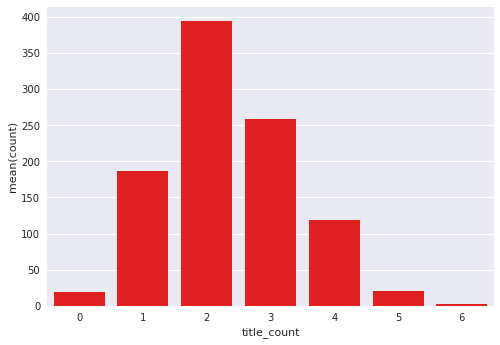

In [24]:
sns.barplot(x='title_count', y='count', data=title_pivot_table, color = "red")
plt.show()


In [25]:
show_pivot_table = pd.pivot_table(temp_df, index='show_count', values='id', aggfunc=len)
show_pivot_table.reset_index(inplace=True)
show_pivot_table.rename(columns={'id' : 'count'}, inplace=True)
print(show_pivot_table)


   show_count  count
0          -1    825
1           0      3
2           1    165
3           2      7


/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


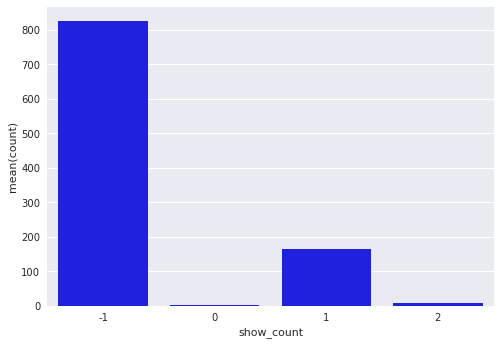

In [28]:
sns.barplot(x='show_count', y='count', data=show_pivot_table, color = "blue")
plt.show()


In [30]:
print(train_doc_keyword_df[['title', 'keyword_list']].head(30))



                                     title             keyword_list
0           《三生三世》里凤九东华最有“夫妻相”，这一模一样的动作是证明           [三生三世, 凤九, 东华]
1         【味集】南宁美食圣地最强攻略！老南宁最爱的味道，都汇集在这些地方                 [南宁, 美食]
2                   据说这些下酒凉菜，只有北京人喜欢，是这样吗？                [凉菜, 北京人]
3   华为新机皇P30pro曝光：麒麟1020＋5G芯片，网友：小米要拿什么来抵挡             [华为, P30pro]
4                   想在泰晤士河边餐厅酒吧看世界杯？戳进来就对啦                [酒吧, 世界杯]
5    看完真的会饿!有人把【烧烤】拍成了纪录片,怒摘9.8高分,市井烟火气太浓~               [烧烤, 人生一串]
6           杨颖跳高只离地10公分，被众人无情嘲笑，惠若琪：你打他牙干嘛           [惠若琪, 杨颖, 奔跑吧]
7                  《我与你的光年距离2》开机王以纶许晓诺纷纷亮相    [我与你的光年距离2, 王以纶, 许晓诺]
8                我国军用无人机和美国差距多大？仅出口总量就差4倍多            [无人机, 军用, 美军]
9                     最喜欢哪一款：别有风情的欧美各国女兵剪影             [女兵, 剪影, 欧美]
10                    哑铃杠铃的4个动作，简单器械助你增肌入门         [增肌, 器械, 哑铃, 杠铃]
11               艺术支教进乡村:让每一个儿童都享受到艺术带来的快乐         [支教, 艺术, 乡村, 儿童]
12              低价外包、外资抵触——第三世界的游戏产业依旧长路漫漫               [第三世界, 游戏]
13           最合适宝宝吃的水果蛋糕，低糖低油高营养，手残党也能一学就会      

In [32]:
print(train_doc_keyword_df[['jieba_title_list', 'title']].head(30))



                                     jieba_title_list  \
0                [三生三世, 凤九, 东华, 最有, 夫妻, 一模一样, 动作, 证明]   
1          [味集, 南宁, 美食, 圣地, 最强, 攻略, 南宁, 爱的味道, 汇集, 地方]   
2                         [据说, 下酒, 凉菜, 北京人, 喜欢, 是这样吗]   
3   [华为, 新机, P30pro, 曝光, 麒麟, 1020, 5G, 芯片, 网友, 小米,...   
4                             [泰晤士河, 餐厅, 酒吧, 世界杯, 进来]   
5      [看完, 真的, 有人, 烧烤, 拍成, 纪录片, 9.8, 高分, 市井, 烟火, 气太]   
6           [杨颖, 跳高, 离地, 10, 公分, 众人, 无情, 嘲笑, 惠若琪, 干嘛]   
7                   [我与你的光年距离2, 开机, 王以纶, 许晓诺, 纷纷, 亮相]   
8                   [我国, 军用, 无人机, 美国, 差距, 多大, 出口, 总量]   
9                      [喜欢, 一款, 别有, 风情, 欧美各国, 女兵, 剪影]   
10                       [哑铃, 杠铃, 动作, 简单, 器械, 增肌, 入门]   
11                   [艺术, 支教, 乡村, 儿童, 享受, 艺术, 带来, 快乐]   
12            [低价, 外包, 外资, 抵触, 第三世界, 游戏, 产业, 依旧, 路漫漫]   
13               [最合适, 宝宝, 水果蛋糕, 低糖, 低油, 营养, 手残党, 一学]   
14                          [纪念品, 海报, 蒂尔, 斯文, 女儿, 合作]   
15           [叙利亚, 彻底, 无奈, 说好, S300, 突然, 不卖, 俄罗斯, 反悔]   
16                             